In [ ]:
# Spark init#save the files in the g drive folder - first two commands
!wget -q https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz 
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/default-java"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"
!pip install -q findspark
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!head -5 /content/drive/MyDrive/Data/zip_code_market_tracker.tsv000

period_begin	period_end	period_duration	region_type	region_type_id	table_id	is_seasonally_adjusted	region	city	state	state_code	property_type	property_type_id	median_sale_price	median_sale_price_mom	median_sale_price_yoy	median_list_price	median_list_price_mom	median_list_price_yoy	median_ppsf	median_ppsf_mom	median_ppsf_yoy	median_list_ppsf	median_list_ppsf_mom	median_list_ppsf_yoy	homes_sold	homes_sold_mom	homes_sold_yoy	pending_sales	pending_sales_mom	pending_sales_yoy	new_listings	new_listings_mom	new_listings_yoy	inventory	inventory_mom	inventory_yoy	months_of_supply	months_of_supply_mom	months_of_supply_yoy	median_dom	median_dom_mom	median_dom_yoy	avg_sale_to_list	avg_sale_to_list_mom	avg_sale_to_list_yoy	sold_above_list	sold_above_list_mom	sold_above_list_yoy	price_drops	price_drops_mom	price_drops_yoy	off_market_in_two_weeks	off_market_in_two_weeks_mom	off_market_in_two_weeks_yoy	parent_metro_region	parent_metro_region_metro_code	last_updated
2017-07-01	2017-09-30	90	zip code	2

In [ ]:
df = spark.read.csv('/content/drive/MyDrive/Data/zip_code_market_tracker.tsv000', sep='\t',header=True)

In [ ]:
df.show(5)

+------------+----------+---------------+-----------+--------------+--------+----------------------+---------------+----+--------+----------+--------------------+----------------+-----------------+---------------------+---------------------+-----------------+---------------------+---------------------+------------------+--------------------+--------------------+------------------+--------------------+--------------------+----------+--------------------+--------------------+-------------+--------------------+--------------------+------------+--------------------+--------------------+---------+--------------------+--------------------+----------------+--------------------+--------------------+----------+--------------+--------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-----------+---------------+---------------+-----------------------+---------------------------+---------------------------+-----------

In [ ]:
df_2 = df.drop("region_type","region_type_id","is_seasonally_adjusted","city","table_id","period_duration","months_of_supply","price_drops","median_sale_price_mom", "median_sale_price_yoy","median_list_price_mom","median_list_price_yoy","median_ppsf_mom","median_ppsf_yoy","median_list_ppsf_mom","median_list_ppsf_yoy","homes_sold_mom","homes_sold_yoy", "pending_sales_mom","pending_sales_yoy","new_listings_mom","new_listings_yoy","inventory_mom","inventory_yoy","months_of_supply_mom","months_of_supply_yoy","median_dom_mom","median_dom_yoy","avg_sale_to_list_mom","avg_sale_to_list_yoy","sold_above_list_mom","sold_above_list_yoy","price_drops_mom","price_drops_yoy","off_market_in_two_weeks_mom","off_market_in_two_weeks_yoy")

In [ ]:
df_2.show(5)

+------------+----------+---------------+--------+----------+--------------------+----------------+-----------------+-----------------+------------------+------------------+----------+-------------+------------+---------+----------+-------------------+-------------------+-----------------------+-------------------+------------------------------+-------------------+
|period_begin|period_end|         region|   state|state_code|       property_type|property_type_id|median_sale_price|median_list_price|       median_ppsf|  median_list_ppsf|homes_sold|pending_sales|new_listings|inventory|median_dom|   avg_sale_to_list|    sold_above_list|off_market_in_two_weeks|parent_metro_region|parent_metro_region_metro_code|       last_updated|
+------------+----------+---------------+--------+----------+--------------------+----------------+-----------------+-----------------+------------------+------------------+----------+-------------+------------+---------+----------+-------------------+------------

In [ ]:
import pyspark.sql.functions as func

In [ ]:
#Distinct count of states in Redfin Dataset
df_states = df_2.select("state_code").distinct().count()
df_states

47

In [ ]:
#Calculating difference of list and sale price and the percentage of that difference
df_3 = df_2.withColumn('DiffOfList&SalePrice', df_2.median_sale_price - df_2.median_list_price)

In [ ]:
df_3.show(5)

+------------+----------+---------------+--------+----------+--------------------+----------------+-----------------+-----------------+------------------+------------------+----------+-------------+------------+---------+----------+-------------------+-------------------+-----------------------+-------------------+------------------------------+-------------------+--------------------+
|period_begin|period_end|         region|   state|state_code|       property_type|property_type_id|median_sale_price|median_list_price|       median_ppsf|  median_list_ppsf|homes_sold|pending_sales|new_listings|inventory|median_dom|   avg_sale_to_list|    sold_above_list|off_market_in_two_weeks|parent_metro_region|parent_metro_region_metro_code|       last_updated|DiffOfList&SalePrice|
+------------+----------+---------------+--------+----------+--------------------+----------------+-----------------+-----------------+------------------+------------------+----------+-------------+------------+---------+-

In [ ]:
from pyspark.sql.functions import *
import datetime
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import sum, col, desc

In [ ]:
#Grouping by period begin and calculating average median sale price
df_4 = df_3.groupBy(year('period_begin')).agg({'median_sale_price':'avg'}).sort(desc(year(df_3.period_begin)))
df_4.show()

+------------------+----------------------+
|year(period_begin)|avg(median_sale_price)|
+------------------+----------------------+
|              2021|    401835.58340094466|
|              2020|     362584.1021330095|
|              2019|    327522.84003192815|
|              2018|     316829.5468317408|
|              2017|      299386.425371486|
|              2016|     281396.7330374789|
|              2015|     262589.8676048179|
|              2014|    236887.72628142938|
|              2013|    222190.99115307556|
|              2012|    203567.84239855543|
+------------------+----------------------+



In [ ]:
#Grouping by state and calculating average median sale price
df_5 = df_3.groupBy('state_code').agg({'median_sale_price':'avg'}).sort(desc('state_code'))
df_5.show()

+----------+----------------------+
|state_code|avg(median_sale_price)|
+----------+----------------------+
|        WV|    176733.04015009382|
|        WI|     185106.2900226178|
|        WA|    354273.73922074697|
|        VT|    238820.19213696892|
|        VA|     346225.8756535498|
|        UT|    295702.58772075834|
|        TX|     228807.7939969535|
|        TN|     202194.1801501387|
|        SC|      220761.695163139|
|        RI|    279043.00771734567|
|        PA|     194589.5040639796|
|        OR|    297355.45440297923|
|        OK|    146274.00966060188|
|        OH|     161808.5762915278|
|        NY|     417966.7571129145|
|        NV|     267678.2945781298|
|        NM|     326475.7256774404|
|        NJ|    335297.06581715145|
|        NH|     252588.6696552374|
|        NE|    186050.03780650455|
+----------+----------------------+
only showing top 20 rows



In [ ]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import *
import datetime
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import sum, col, desc
from pyspark.sql.functions import lit

In [ ]:
#Calculating difference between median sale price

my_window = Window.partitionBy().orderBy("period_begin")

df_3 = df_3.withColumn("prev_value", F.lag("median_sale_price").over(my_window))
df_3 = df_3.withColumn("diff", F.when(F.isnull(df_3.median_sale_price - df_3.prev_value), 0)
                              .otherwise(df_3.median_sale_price - df_3.prev_value))

df_3.show()

+------------+----------+---------------+-------------+----------+--------------------+----------------+-----------------+-----------------+------------------+------------------+----------+-------------+------------+---------+----------+-------------------+--------------------+-----------------------+--------------------+------------------------------+-------------------+--------------------+----------+---------+
|period_begin|period_end|         region|        state|state_code|       property_type|property_type_id|median_sale_price|median_list_price|       median_ppsf|  median_list_ppsf|homes_sold|pending_sales|new_listings|inventory|median_dom|   avg_sale_to_list|     sold_above_list|off_market_in_two_weeks| parent_metro_region|parent_metro_region_metro_code|       last_updated|DiffOfList&SalePrice|prev_value|     diff|
+------------+----------+---------------+-------------+----------+--------------------+----------------+-----------------+-----------------+------------------+-------

In [ ]:
#Grouping by state and calculating average difference of median sale price
df_6 = df_3.groupBy('state_code').agg({'diff':'avg'}).sort(desc('state_code'))
df_6.show()

+----------+-------------------+
|state_code|          avg(diff)|
+----------+-------------------+
|        WV|-110408.55942776735|
|        WI|-122563.16650400459|
|        WA| 59871.220940182735|
|        VT| -50599.69678308375|
|        VA|  52924.34346192212|
|        UT| -9981.502163889674|
|        TX| -62635.91684831851|
|        TN| -107012.4056138824|
|        SC| -91005.09704286697|
|        RI| -9225.830760884783|
|        PA| -95261.13769621917|
|        OR|  6864.239373305035|
|        OK| -147332.9635285987|
|        OH|-128705.95788492034|
|        NY| 119268.69354289245|
|        NV|-23636.838470910752|
|        NM|  29495.59345412994|
|        NJ|  33633.41153868969|
|        NH| -37732.71059327168|
|        NE|-104309.95110033857|
+----------+-------------------+
only showing top 20 rows



Text(0.5, 1.0, 'Date Vs. Median Sale Price of Redfin Data')

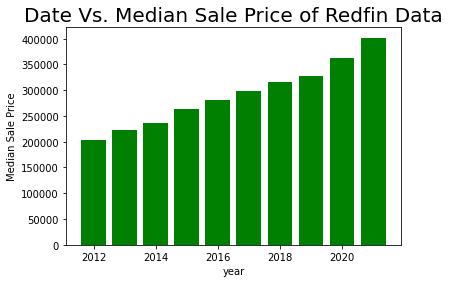

In [ ]:
# convert dataframe to dictionary 
import matplotlib.pyplot as plt
dict = df_4.rdd.collectAsMap()
plt.bar(list(dict.keys()), dict.values(), color='g')
plt.xlabel("year",fontsize=10)
plt.ylabel("Median Sale Price",fontsize=10)
plt.title("Date Vs. Median Sale Price of Redfin Data",fontsize=20)

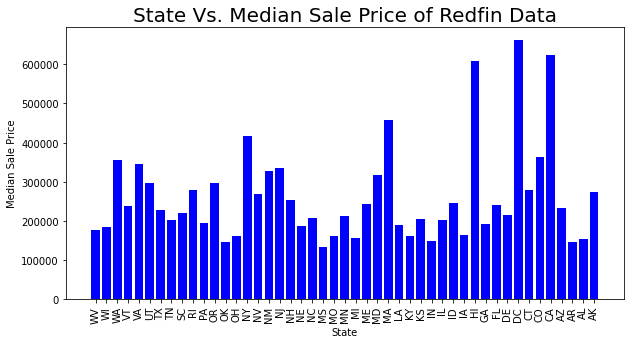

In [ ]:
# convert dataframe to dictionary 
import matplotlib.pyplot as plt
dict = df_5.rdd.collectAsMap()
plt.bar(list(dict.keys()), dict.values(), color='b')
plt.xlabel("State",fontsize=10)
plt.xticks(rotation=90)
plt.ylabel("Median Sale Price",fontsize=10)
plt.title("State Vs. Median Sale Price of Redfin Data",fontsize=20)
plt.gcf().set_size_inches(10,5)

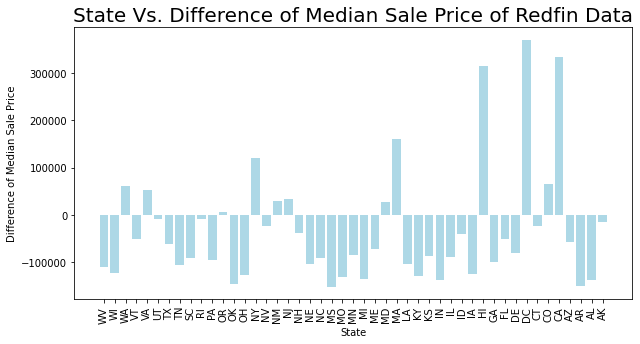

In [ ]:
import matplotlib.pyplot as plt
dict = df_6.rdd.collectAsMap()
plt.bar(list(dict.keys()), dict.values(), color='lightblue')
plt.xlabel("State",fontsize=10)
plt.xticks(rotation=90)
plt.ylabel("Difference of Median Sale Price",fontsize=10)
plt.title("State Vs. Difference of Median Sale Price of Redfin Data",fontsize=20)
plt.gcf().set_size_inches(10,5)

In [ ]:
df_7 = df_3.groupBy('state_code').agg({'homes_sold':'sum'}).sort(desc('state_code'))

df_7.show()

+----------+-----------------+
|state_code|  sum(homes_sold)|
+----------+-----------------+
|        WV|         231252.0|
|        WI|        3154471.0|
|        WA|        6199993.0|
|        VT|         341600.0|
|        VA|5122223.077272727|
|        UT|        2483498.0|
|        TX|      1.6001439E7|
|        TN|        4232576.0|
|        SC|        3155930.0|
|        RI|         831618.0|
|        PA|        6835910.0|
|        OR|        3433796.0|
|        OK|        2358712.0|
|        OH|        7672028.0|
|        NY|        6753402.0|
|        NV|        3229686.0|
|        NM|         157080.0|
|        NJ|        5826306.0|
|        NH|        1188340.0|
|        NE|        1069648.0|
+----------+-----------------+
only showing top 20 rows



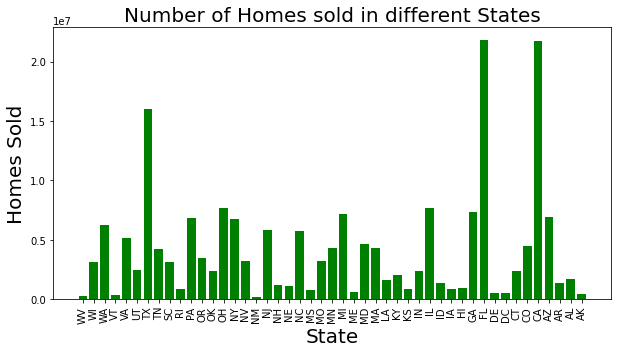

In [ ]:
import matplotlib.pyplot as plt



dict = df_7.rdd.collectAsMap()

plt.bar(list(dict.keys()), dict.values(), color='g')

plt.xlabel("State",fontsize=20)

plt.xticks(rotation=90)

plt.ylabel("Homes Sold",fontsize=20)

plt.title("Number of Homes sold in different States",fontsize=20)

plt.gcf().set_size_inches(10,5)

In [ ]:
df_8 = df_3.groupBy(year('period_begin')).agg({'homes_sold':'sum'}).sort(desc(year('period_begin')))
df_8.show()

+------------------+--------------------+
|year(period_begin)|     sum(homes_sold)|
+------------------+--------------------+
|              2021|2.1533061077272728E7|
|              2020|         2.2866549E7|
|              2019|         2.1703071E7|
|              2018|         2.1294619E7|
|              2017|         2.1464567E7|
|              2016|         2.0865718E7|
|              2015|         1.9596315E7|
|              2014|         1.6961296E7|
|              2013|         1.6730922E7|
|              2012|         1.4728368E7|
+------------------+--------------------+



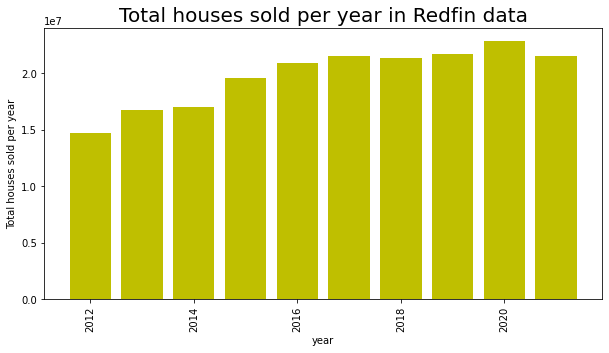

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

dict = df_8.rdd.collectAsMap()
plt.bar(list(dict.keys()), dict.values(), color='y')
plt.xlabel("year",fontsize=10)
plt.xticks(rotation=90)

plt.ylabel("Total houses sold per year",fontsize=10)
plt.title("Total houses sold per year in Redfin data",fontsize=20)
plt.gcf().set_size_inches(10,5)

In [ ]:
for field in df.schema.fields:
    print(field.name +" , ")

period_begin , 
period_end , 
period_duration , 
region_type , 
region_type_id , 
table_id , 
is_seasonally_adjusted , 
region , 
city , 
state , 
state_code , 
property_type , 
property_type_id , 
median_sale_price , 
median_sale_price_mom , 
median_sale_price_yoy , 
median_list_price , 
median_list_price_mom , 
median_list_price_yoy , 
median_ppsf , 
median_ppsf_mom , 
median_ppsf_yoy , 
median_list_ppsf , 
median_list_ppsf_mom , 
median_list_ppsf_yoy , 
homes_sold , 
homes_sold_mom , 
homes_sold_yoy , 
pending_sales , 
pending_sales_mom , 
pending_sales_yoy , 
new_listings , 
new_listings_mom , 
new_listings_yoy , 
inventory , 
inventory_mom , 
inventory_yoy , 
months_of_supply , 
months_of_supply_mom , 
months_of_supply_yoy , 
median_dom , 
median_dom_mom , 
median_dom_yoy , 
avg_sale_to_list , 
avg_sale_to_list_mom , 
avg_sale_to_list_yoy , 
sold_above_list , 
sold_above_list_mom , 
sold_above_list_yoy , 
price_drops , 
price_drops_mom , 
price_drops_yoy , 
off_market_in_two_weeks

In [ ]:
for field in df_3.schema.fields:
    print(field.name +" , ")

period_begin , 
period_end , 
region , 
state , 
state_code , 
property_type , 
property_type_id , 
median_sale_price , 
median_list_price , 
median_ppsf , 
median_list_ppsf , 
homes_sold , 
pending_sales , 
new_listings , 
inventory , 
median_dom , 
avg_sale_to_list , 
sold_above_list , 
off_market_in_two_weeks , 
parent_metro_region , 
parent_metro_region_metro_code , 
last_updated , 
DiffOfList&SalePrice , 
prev_value , 
diff , 


In [ ]:
import requests 
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()